In [2]:
from lavis.datasets.builders import load_dataset
from lavis.models import load_model_and_preprocess
from scipy.ndimage import binary_erosion
from PIL import Image
from typing import List, Tuple
from algo import (
    PITOME,
    TOME,
    DIFFRATE,
    TOFU,
    NONE, 
    pitome,
    tome,
    DiffRate,
    tofu,
)
import numpy as np
import torch
import torch.nn.functional as F
from omegaconf import OmegaConf
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
from lavis.processors.blip_processors import BlipImageBaseProcessor



device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model, vis_processors, text_processors = load_model_and_preprocess("blip_image_text_matching", 'base', device=device,is_eval=True)
dataset = load_dataset("coco_retrieval", cfg_path=None)



Using downloaded and verified file: /media/caduser/da936c0b-edd7-470e-ab92-9b972b220fe7/chau/coco/annotations/coco_karpathy_train.json
Using downloaded and verified file: /media/caduser/da936c0b-edd7-470e-ab92-9b972b220fe7/chau/coco/annotations/coco_karpathy_val.json
Using downloaded and verified file: /media/caduser/da936c0b-edd7-470e-ab92-9b972b220fe7/chau/coco/annotations/coco_karpathy_test.json


In [3]:
class BlipImageEvalProcessor(BlipImageBaseProcessor):
    def __init__(self, image_size=384, mean=None, std=None):
        super().__init__(mean=mean, std=std)

      
        transform_list = [
            transforms.Resize(
                (image_size, image_size), interpolation=InterpolationMode.BICUBIC
            ),
        ]

        # The visualization and model need different transforms
        self.transform_vis  = transforms.Compose(transform_list)
        self.transform = transforms.Compose(transform_list + [
            transforms.ToTensor(),
            self.normalize,
        ])

    def __call__(self, item):
        return self.transform_vis(item), self.transform(item)

    @classmethod
    def from_config(cls, cfg=None):
        if cfg is None:
            cfg = OmegaConf.create()

        image_size = cfg.get("image_size", 384)

        mean = cfg.get("mean", None)
        std = cfg.get("std", None)

        return cls(image_size=image_size, mean=mean, std=std)

processor = BlipImageEvalProcessor() 


In [4]:

ALGOS = {
    PITOME: pitome, 
    TOME: tome, 
    DIFFRATE: DiffRate, 
    TOFU: tofu, 
}

def get_model(model, algo, ratio):
    if algo == DIFFRATE:
        ALGOS[algo].patch.blip(model.visual_encoder, trace_source=True, output_attn=True)
        ALGOS[algo].patch.blip(model.visual_encoder_m, trace_source=True, output_attn=True)
        model.visual_encoder.init_kept_num_using_ratio(ratio)
        model.visual_encoder_m.init_kept_num_using_ratio(ratio)
    elif algo != NONE:
        ALGOS[algo].patch.blip(model.visual_encoder, trace_source=True, output_attn=True)
        ALGOS[algo].patch.blip(model.visual_encoder_m, trace_source=True, output_attn=True)
        model.visual_encoder.ratio=ratio
        model.visual_encoder_m.ratio=ratio
    else:
        ALGOS[TOME].patch.blip(model.visual_encoder, trace_source=True, output_attn=True)
        ALGOS[TOME].patch.blip(model.visual_encoder_m, trace_source=True, output_attn=True)
        model.visual_encoder.ratio=1.0
        model.visual_encoder_m.ratio=1.0



In [5]:

import cv2

def overlay_img(image1, image2, alpha, output_path='overlayed_img.png'):
    # Read the images
    # print(image1, image2)
    image1 = np.array(image1)
    image2 = np.array(image2)
    image1 = cv2.cvtColor(image1, cv2.COLOR_RGB2BGR)
    image2 = cv2.cvtColor(image2, cv2.COLOR_RGB2BGR)

    overlay = cv2.addWeighted(image2, 1- alpha, image1, alpha, 0)
    print(output_path)
    cv2.imwrite(output_path, overlay)
    return overlay



def generate_colormap(N: int, attention_score: torch.Tensor, seed: int = 0) -> List[Tuple[float, float, float]]:
  """
  Generates a colormap with N elements, with a bolder blue base and lightness adjusted based on attention scores.

  Args:
      N: Number of colors to generate.
      attention_score: A torch.Tensor representing the attention scores.
          This will be used to modulate the lightness of the blue color.
      seed: An optional integer seed for reproducibility.

  Returns:
      A list of tuples representing RGB color values (0.0 to 1.0).
  """



  def adjust_lightness(attention_value):
    normalized_attention = (attention_value - attention_score.min()) / (attention_score.max() - attention_score.min())
    # lightness_adjustment =  normalized_attention  # Adjust factor for lightness range
    base = (0.0, 0.0, 0.0)
    adjusted_color = [base[0], base[1]+1.0*normalized_attention, base[2]+1.0*normalized_attention]
    return tuple(max(0.0, min(1.0, val)) for val in adjusted_color)

  colormap = [adjust_lightness(attention_value) for attention_value in attention_score.flatten().tolist()]
  return colormap

def make_visualization(
    img: Image, source: torch.Tensor, attention_score:torch.Tensor, patch_size: int = 16, class_token: bool = True
) -> Image:
    """
    Create a visualization like in the paper.

    Args:
     -

    Returns:
     - A PIL image the same size as the input.
    """

    img = np.array(img.convert("RGB")) / 255.0
    source = source.detach().cpu()

    h, w, _ = img.shape
    ph = h // patch_size
    pw = w // patch_size

    if class_token:
        source = source[:, :, 1:]
    vis = source.argmax(dim=1)
    num_groups = vis.max().item() + 1
    print('num_group',num_groups)

    cmap = generate_colormap(num_groups, attention_score)
    vis_img = 0

    for i in range(num_groups):
        mask = (vis == i).float().view(1, 1, ph, pw)
        mask = F.interpolate(mask, size=(h, w), mode="nearest")
        mask = mask.view(h, w, 1).numpy()

        color = (mask * img).sum(axis=(0, 1)) / mask.sum()
        mask_eroded = binary_erosion(mask[..., 0], iterations=1)[..., None]
        mask_edge = mask - mask_eroded

        if not np.isfinite(color).all():
            color = np.zeros(3)
        

        vis_img = vis_img + mask_eroded * color.reshape(1, 1, 3) 
        vis_img = vis_img + mask_edge * 4* np.array(cmap[i]).reshape(1, 1, 3)

    # Convert back into a PIL image
    vis_img = Image.fromarray(np.uint8(vis_img * 255))

    return vis_img


In [6]:
import os
def visualize(algo, ratio, index=None, path=None):
    path = f'{os.getcwd()}/examples/images/image.jpg'
    model, _, _ = load_model_and_preprocess("blip_retrieval", "coco", is_eval=False)
    get_model(model,algo, ratio)
    model.eval()
    with torch.no_grad():
        if index is not None:
            img = dataset['train'][index]['image']
            print(dataset['train'][index]['text_input'])
        else:
            img = Image.open(path)

        img_vis, img_input = processor(img)
        model.visual_encoder(img_input[None,...])
        source = model.visual_encoder._info['source']
        attn = model.visual_encoder.blocks[-1].attn.attention_map
            # print(attn.shape)

        # source = model.visual_encoder._info['sources'][1]
        # print(source.shape)
    merged_img = make_visualization(img_vis, source, attn.sum(1)[:, 0, :], patch_size=16, class_token=True)

    # alpha = 0.4
    # final_img = overlay_img(img_vis, merged_img, alpha, output_path=f"{os.getcwd()}/outputs/overlayed_img.jpg") 
    # return  Image.fromarray(np.uint8(final_img * 255))
    return merged_img 

using pitome
using pitome
A white dog catching a novelty flying disc in a competition.
torch.Size([1, 187, 768])
torch.Size([1, 160, 768])
torch.Size([1, 137, 768])
torch.Size([1, 117, 768])
num_group 100


/tmp/ipykernel_35763/4233771635.py:78: RuntimeWarning: invalid value encountered in divide
  color = (mask * img).sum(axis=(0, 1)) / mask.sum()


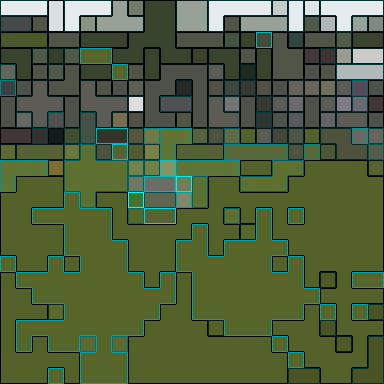

In [7]:
ratio = 0.85
# index = 102 
# index = 300 
# index = 6400 
# index = 6665 
# index = 21110 
# index = 15500 
index = 25000 
# index = 37000 
# index = 47000 
# index = 58000 
# index = 69000 
# index = 25000 
visualization = visualize(PITOME, ratio, index)
# visualize(PITOME,  ratio)
visualization
# visualization

using tome
using tome
A white dog catching a novelty flying disc in a competition.
num_group 99


/tmp/ipykernel_35763/4233771635.py:78: RuntimeWarning: invalid value encountered in divide
  color = (mask * img).sum(axis=(0, 1)) / mask.sum()


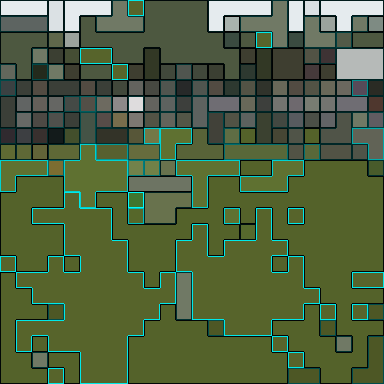

In [8]:
visualize(TOME, ratio, index)
# visualize(TOME, ratio)

using tofu
using tofu
A white dog catching a novelty flying disc in a competition.
num_group 99


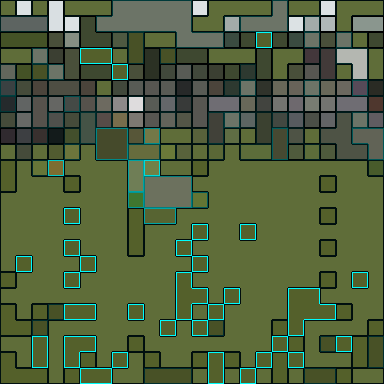

In [9]:
visualize(TOFU,  ratio, index)

In [10]:
# # visualize(DIFFRATE,  ratio)
# visualize(DIFFRATE,  ratio, index)[1]

using tome
using tome
A white dog catching a novelty flying disc in a competition.
num_group 577


/tmp/ipykernel_35763/4233771635.py:78: RuntimeWarning: invalid value encountered in divide
  color = (mask * img).sum(axis=(0, 1)) / mask.sum()


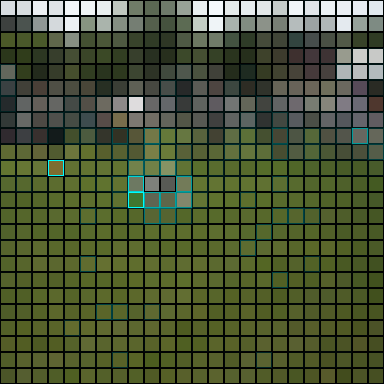

In [11]:
visualize(NONE, ratio=1.0, index=index)
# visualize(NONE, ratio=1.0)